# Review Classification

The goal of this project is to build a classifier which determines whether a given review is spam or non-spam. The dataset contains truthful and deceptive (spam) reviews for hotels. This includes initializing the data, data pre-processing, feature-selection, creating visualizations, creating models, and measuring their performance.



This coding segment will handle any imports that we will use for the project. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import re
import nltk
from nltk.stem import PorterStemmer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics




# **Loading of Data**

The following code segment will handle loading in the data and setting the feature target values as the data is given to us as text files and are indicated as spam either by the file name or the folder name. To load the data, please righr click on the sample_data file folder and choose upload. Then upload the negative_polarity and positive_polarity folders from the project dataset.

Beware that this segment can take 10+ mins to execute.

In [4]:
# import required module
import os
from collections import defaultdict
from pathlib import Path
import pandas as pd

def getFiles(path, target, temp):
    for dir in os.listdir(path):
        for files in os.listdir(path + dir):
            with open(path + dir + "/" + files, "r") as file_open:
                temp["file_name"].append(files)
                temp["text"].append(file_open.read())
                temp["target"].append(target)
                temp["hotel"].append(files.split('_')[1])
    return temp


results = defaultdict(list)

path = 'data/negative_polarity/deceptive_from_MTurk/'

getFiles(path, 1, results)

path = 'data/negative_polarity/truthful_from_Web/'

getFiles(path, 0, results)

path = 'data/positive_polarity/deceptive_from_MTurk/'

getFiles(path, 1, results)

path = 'data/positive_polarity/truthful_from_TripAdvisor/'

getFiles(path, 0, results)

df = pd.DataFrame(results)
df

,file_name,text,target,hotel
0,d_talbott_9.txt,The Talbott Hotel claims to be Chicago's Premi...,1,talbott
1,d_talbott_8.txt,I selected The Talbott for my recent family va...,1,talbott
2,d_affinia_20.txt,I recently stayed at the Affinia Hotel in Chic...,1,affinia
3,d_hardrock_18.txt,My husband and I stayed here at the Hard Rock ...,1,hardrock
4,d_hardrock_19.txt,I stayed at the Hard Rock Hotel in Chicago rec...,1,hardrock
...,...,...,...,...
1595,t_james_18.txt,My significant other and I recently spent 3 ni...,0,james
1596,t_monaco_1.txt,This is a great hotel! From the doorman who gr...,0,monaco
1597,t_james_19.txt,I believe I can not describe how amazing was o...,0,james
1598,t_monaco_3.txt,Stayed at the Monaco for a romantic weekend ge...,0,monaco


In [5]:
df['target'].value_counts()

1    800
0    800
Name: target, dtype: int64

# **Data Preprocessing**

Data preprocessing is a crucial stage in Machine Learning because the quality of data and the relevant information that can be extracted from it has a direct impact on our model's capacity to learn. Therefore, preprocessing our data before feeding it into our model is critical.

## **Get list of most commonly used words**

After preprocessing the reviews, we have a list of words for each review. The next step we choose which words we would like to use in our classifier and which we would want to leave out. For this, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list. The complete vocabulary list is in the file vocab.txt. Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word indices that contains the index of the word in the vocabulary list. In the code, we are giving a string str which is a single word from the processed review. We then look up the word in the vocabulary list vocabList and find if the word exists in the vocabulary list. If the word exists, we then add the index of the word into the word indices variable. If the word does not exist, and is therefore not in the vocabulary, we skip the word. The code below will load the vocab.txt file to get list of most frequently used words.

In [ ]:
# To get the list of words from the text file vocab.txt
def getVocabList():
  
  # Reading the txt file
    data = pd.read_csv("vocab.txt", sep='\t')

    words = []

  # Appending the words to create the final list
    for index, row in data.iterrows():
        words.append(row["aa"])
  
  # Returning the final set of words
    return words

## Preprocessing of Reviews

We follow the below steps to preprocess reviews

*  **Lower-casing:** The entire review is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as indicate)
*  **Stripping HTML:** All HTML tags are removed from the reviews. Many reviews often come with HTML formatting. We remove all the HTML tags, so that only the content remains.
*  **Normalizing URLs:** All URLs are replaced with the text "httpaddr".
*  **Normalizing Email Addresses:** All email addresses are replaced with the text "emailaddr".
*  **Normalizing Numbers:** All numbers are replaced with the text 'number'.
*  **Normalizing Dollars:** All dollar signs ($) are replaced with the text 'dollar'.
*  **Word Stemming:** Words are reduced to their stemmed form. For example, 'discount', 'discounts', 'discounted' and 'discounting' are all replaced with 'discount'. Sometimes, the Stemmer actually strips off additional characters from the end, so 'include', 'includes', 'included', and 'including' are all replaced with 'includ'.
*  **Removal of non-words:** Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

The function below does the preprocessing of a review


In [ ]:
def processReviews(review):

    wordList = getVocabList()

    wordIndices = []

  # To convert all the characters to lower case
    review = review.lower()

  # To remove HTML tags
    review = re.sub('<[^<>]+>', '', review)

  # To handle number
    review = re.sub('[0-9]+', 'number', review)

  # To handle URLS
    review = re.sub('(http|https)://[^\s]*', 'httpaddr', review)

  # To handle Email Address
    review = re.sub('[^\s]+@[^\s]+', 'emailaddr', review)

  # To handle $ sign
    review = re.sub('[$]+', 'dollar', review)
  
    words = review.split(" ")

    review = []

    for word in words:

    # To remove non alphabatic characters, like punctation
        word = re.sub('[^a-zA-Z0-9]', '', word)

    # Stemming
        porter = PorterStemmer()
        word = porter.stem(word)

        if len(word) < 1:
            continue
      
    # To create list of index
        for index,vocab in enumerate(wordList):
            if(word == vocab):
                review.append(str(index))

        review = " ".join(review)

    return review
  

In [ ]:
#Example
processReviews("My name is Manoj! trouble troubling troubled <Home><\Home> 12 https://www.google.com/ manojkar@uw.edu $12")

'1082 1084 875 1728 1728 1728 1118 797 529 477'

This code segment also takes some time to execute.

In [ ]:
df["pre_text"] = df["text"].apply(lambda x: processReviews(x))
df

,file_name,text,target,hotel,pre_text
0,d_knickerbocker_4.txt,While the hotel certainly seems to look beauti...,1,knickerbocker,1839 1664 266 1469 1697 974 1664 875 18 614 68...
1,d_sheraton_2.txt,The Sheraton Chicago Hotel and Towers is not t...,1,sheraton,1664 72 875 1111 1664 664 1240 1857 1697 754 1...
2,d_knickerbocker_10.txt,After a my stay at the Millennium Knickerbocke...,1,knickerbocker,37 1082 122 1664 1664 1664 1271 1345 1160 1082...
3,d_homewood_17.txt,"Whatever you do, do NOT stay at the Homewood S...",1,homewood,1834 1891 469 469 1111 122 1664 1614 823 987 1...
4,d_knickerbocker_6.txt,The Millennium Knickerbocker Hotel has seen be...,1,knickerbocker,1664 741 1470 176 743 1025 1160 1671 1835 881 ...
...,...,...,...,...,...
1595,t_amalfi_1.txt,"This hotel cannot be beat for location, price,...",0,amalfi,1674 238 160 161 664 968 1297 1664 968 875 122...
1596,t_amalfi_4.txt,"We stayed for just one night ,but the hotel st...",0,amalfi,1817 664 900 1103 223 1664 1577 1801 602 72 12...
1597,t_amalfi_6.txt,I would definitely recommend this hotel to any...,0,amalfi,1874 419 1374 1674 1697 84 1807 823 1276 979 1...
1598,t_amalfi_18.txt,"Review's a little late, but... My husband & I ...",0,amalfi,1419 961 927 223 1082 650 122 1664 823 1711 15...


In [ ]:
def getAVG(vals):
  nums = [int(x) for x in vals.split(' ')]
  count = 0
  for num in nums:
    count = count + num
  return count / len(nums)

In [ ]:
#Example
getAVG(processReviews("My name is Manoj! trouble troubling troubled <Home><\Home> 12 https://www.google.com/ manojkar@uw.edu $12"))

1114.6

# **Data Visualization**

Here we are looking at some of the data features. As you can see, there are not many visual differences between the truthful and deceitful data. This makes sense as the goal of deceitful data is to look as similar to truthful data as possible. If there were easy to spot visual differnces, the problem of finding opinion spam would be trivial


In [ ]:
df["average"] = df["pre_text"].apply(lambda x: getAVG(x))
df

,file_name,text,target,hotel,pre_text,average
0,d_knickerbocker_4.txt,While the hotel certainly seems to look beauti...,1,knickerbocker,1839 1664 266 1469 1697 974 1664 875 18 614 68...,879.510204
1,d_sheraton_2.txt,The Sheraton Chicago Hotel and Towers is not t...,1,sheraton,1664 72 875 1111 1664 664 1240 1857 1697 754 1...,1159.344828
2,d_knickerbocker_10.txt,After a my stay at the Millennium Knickerbocke...,1,knickerbocker,37 1082 122 1664 1664 1664 1271 1345 1160 1082...,1126.664234
3,d_homewood_17.txt,"Whatever you do, do NOT stay at the Homewood S...",1,homewood,1834 1891 469 469 1111 122 1664 1614 823 987 1...,1018.008621
4,d_knickerbocker_6.txt,The Millennium Knickerbocker Hotel has seen be...,1,knickerbocker,1664 741 1470 176 743 1025 1160 1671 1835 881 ...,1092.000000
...,...,...,...,...,...,...
1595,t_amalfi_1.txt,"This hotel cannot be beat for location, price,...",0,amalfi,1674 238 160 161 664 968 1297 1664 968 875 122...,1039.163462
1596,t_amalfi_4.txt,"We stayed for just one night ,but the hotel st...",0,amalfi,1817 664 900 1103 223 1664 1577 1801 602 72 12...,970.962963
1597,t_amalfi_6.txt,I would definitely recommend this hotel to any...,0,amalfi,1874 419 1374 1674 1697 84 1807 823 1276 979 1...,1200.117647
1598,t_amalfi_18.txt,"Review's a little late, but... My husband & I ...",0,amalfi,1419 961 927 223 1082 650 122 1664 823 1711 15...,1169.264706


In [ ]:
df.groupby('target', as_index=False)['average'].mean()

,target,average
0,0,1093.789130
1,1,1095.710043


In [ ]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['text'])

df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))

In [ ]:
df

,file_name,text,target,hotel,pre_text,average,Review Text,polarity,review_len,word_count
0,d_knickerbocker_4.txt,While the hotel certainly seems to look beauti...,1,knickerbocker,1839 1664 266 1469 1697 974 1664 875 18 614 68...,879.510204,While the hotel certainly seems to look beauti...,0.073469,341,61
1,d_sheraton_2.txt,The Sheraton Chicago Hotel and Towers is not t...,1,sheraton,1664 72 875 1111 1664 664 1240 1857 1697 754 1...,1159.344828,The Sheraton Chicago Hotel and Towers is not t...,0.214286,874,150
2,d_knickerbocker_10.txt,After a my stay at the Millennium Knickerbocke...,1,knickerbocker,37 1082 122 1664 1664 1664 1271 1345 1160 1082...,1126.664234,After a my stay at the Millennium Knickerbocke...,-0.069643,985,186
3,d_homewood_17.txt,"Whatever you do, do NOT stay at the Homewood S...",1,homewood,1834 1891 469 469 1111 122 1664 1614 823 987 1...,1018.008621,"Whatever you do, do NOT stay at the Homewood S...",-0.116592,880,162
4,d_knickerbocker_6.txt,The Millennium Knickerbocker Hotel has seen be...,1,knickerbocker,1664 741 1470 176 743 1025 1160 1671 1835 881 ...,1092.000000,The Millennium Knickerbocker Hotel has seen be...,0.177646,817,148
...,...,...,...,...,...,...,...,...,...,...
1595,t_amalfi_1.txt,"This hotel cannot be beat for location, price,...",0,amalfi,1674 238 160 161 664 968 1297 1664 968 875 122...,1039.163462,"This hotel cannot be beat for location, price,...",0.380455,841,149
1596,t_amalfi_4.txt,"We stayed for just one night ,but the hotel st...",0,amalfi,1817 664 900 1103 223 1664 1577 1801 602 72 12...,970.962963,"We stayed for just one night ,but the hotel st...",0.505595,391,68
1597,t_amalfi_6.txt,I would definitely recommend this hotel to any...,0,amalfi,1874 419 1374 1674 1697 84 1807 823 1276 979 1...,1200.117647,I would definitely recommend this hotel to any...,0.391981,487,75
1598,t_amalfi_18.txt,"Review's a little late, but... My husband & I ...",0,amalfi,1419 961 927 223 1082 650 122 1664 823 1711 15...,1169.264706,"Review's a little late, but... My husband & I ...",0.273958,525,97


In [ ]:
df.groupby('target', as_index=False)['review_len'].mean()

,target,review_len
0,0,821.0150
1,1,791.7675


In [ ]:
df.groupby('target', as_index=False)['word_count'].mean()

,target,word_count
0,0,150.91375
1,1,146.63625


In [ ]:
df.groupby('target', as_index=False)['polarity'].mean()

,target,polarity
0,0,0.203070
1,1,0.196947


In [ ]:
df.groupby(['hotel', 'target'], as_index=False)['polarity'].mean()

,hotel,target,polarity
0,affinia,0,0.175145
1,affinia,1,0.230267
2,allegro,0,0.162500
3,allegro,1,0.178766
4,amalfi,0,0.221881
5,amalfi,1,0.236164
6,ambassador,0,0.209726
7,ambassador,1,0.176530
8,conrad,0,0.218139
9,conrad,1,0.199004


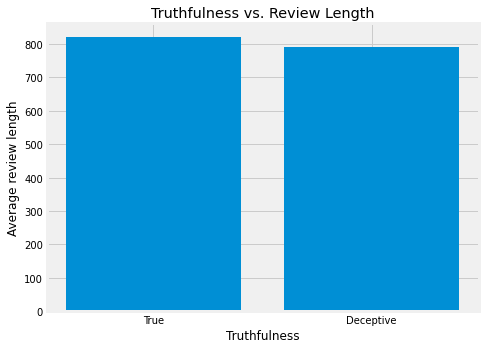

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['True', 'Deceptive'], df.groupby('target', as_index=False)['review_len'].mean()['review_len'])
plt.title("Truthfulness vs. Review Length")
plt.xlabel("Truthfulness")
plt.ylabel("Average review length")
plt.show()

# Testing Splits

This is where we will split the data into our testing and training splits. As you can see from the code, we have decided to follow convention and train using %80 of the data and test using the other %20. Before we handle the data, we create 3 separate copies for each of us to use to ensure that each model uses fresh data that hasn't been modified more than it has been already up to this point.

In [ ]:
# Splitting based on our chosen feature to train with.
X = df["Review Text"]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=115)

SVM_X_train = X_train
MLP_X_train = X_train
DTC_X_train = X_train

SVM_X_test = X_test
MLP_X_test = X_test
DTC_X_test = X_test

SVM_y_train = y_train
MLP_y_train = y_train
DTC_y_train = y_train

SVM_y_test = y_test
MLP_y_test = y_test
DTC_y_test = y_test

MLP_X_test
DTC_X_test

1504    The Sheraton is a fantastic hotel. My wife and...
107     I stayed here last August and I'm truly glad t...
84      When I went to The James hotel in Chicago I tr...
385     I will never stay at Conrad Chicago again. The...
780     We recently stayed at the hotel allegro in chi...
                              ...                        
1474    I loved this hotel - fabulous old building but...
469     Under the gloss of a nice building, friendly s...
284     We originally made reservations for a weekend ...
218     This hotel is ok but is not the best for the m...
1215    Just putting in a good word for the Hard Rock ...
Name: Review Text, Length: 320, dtype: object

# MLP Classifier

For the first of our chosen models, we have decided to create a MLP or a multi-layer perceptron model. The goal of this model is to optimize its given loss model and backpropagates accordingly based on the output. We stick fairly close to defualt for the parameters for reasons that will be mentioned later.

In [ ]:
vectorizer = TfidfVectorizer()
MLP_X_train = vectorizer.fit_transform(MLP_X_train)
MLP_X_test = vectorizer.transform(MLP_X_test)
vectorizer.get_feature_names_out()
MLP_X_train

<1280x8510 sparse matrix of type '<class 'numpy.float64'>'
	with 116457 stored elements in Compressed Sparse Row format>

In [ ]:
mlp = MLPClassifier(random_state=1, max_iter=200).fit(MLP_X_train, MLP_y_train)

In [ ]:
MLP_X_test

<320x8510 sparse matrix of type '<class 'numpy.float64'>'
	with 28906 stored elements in Compressed Sparse Row format>

In [ ]:
mlp_predict = mlp.predict(MLP_X_test)
mlp_predict
print('Accuracy:\n' + 'MLP: ' + str(accuracy_score(MLP_y_test, mlp_predict)))
print(metrics.classification_report(MLP_y_test, mlp_predict))


Accuracy:
MLP: 0.8875
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       171
           1       0.88      0.88      0.88       149

    accuracy                           0.89       320
   macro avg       0.89      0.89      0.89       320
weighted avg       0.89      0.89      0.89       320



## Parameter Tuning

I originally planned on parameter tuning, but running the GridSearchCV sklearn package on my code took +1hr each time and yielded negligible improvements to the accuracy so I decided to stick with the default classifier with max_iter bumped up to 300 instead of the default 200.

# SVM Classifier

The "Support Vector Machine" (SVM) is a supervised machine learning technique that can solve classification and regression problems. It is, however, mostly employed to solve categorization difficulties. Each data item is plotted as a point in n-dimensional space (where n is the number of features you have), with the value of each feature being the value of a certain coordinate in the SVM algorithm. Then we accomplish classification by locating the hyper-plane that clearly distinguishes the two classes 

In [ ]:
# Implementing Vectoriser

vectorizer = TfidfVectorizer()
SVM_X_train_v = vectorizer.fit_transform(SVM_X_train)
SVM_X_test_v = vectorizer.transform(SVM_X_test)

In [ ]:
#SVM Model

svm_model = svm.SVC(kernel='linear')
svm_model.fit(SVM_X_train_v, SVM_y_train)

SVC(kernel='linear')

In [ ]:
# Prediction
SVM_pred_test = svm_model.predict(SVM_X_test_v)
print(classification_report(SVM_y_test, SVM_pred_test))


              precision    recall  f1-score   support

           0       0.90      0.85      0.87       171
           1       0.84      0.89      0.86       149

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



## **Paramatter Tuning**

Hyper-parameters are variables that aren't learned directly by estimators. They are supplied as inputs to the constructor of the estimator classes in scikit-learn. Grid search is a technique of hyper-parameter tuning that builds and evaluates a model systematically for each combination of algorithm parameters supplied on a grid.

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(svm_model, param_grid, refit = True, verbose = 3)
 

In [ ]:
grid.fit(SVM_X_train_v, SVM_y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.512 total time=   1.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.508 total time=   1.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.512 total time=   1.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.508 total time=   1.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [ ]:
grid_predictions = grid.predict(SVM_X_test_v)
print(classification_report(SVM_y_test, grid_predictions))


              precision    recall  f1-score   support

           0       0.89      0.88      0.88       171
           1       0.86      0.88      0.87       149

    accuracy                           0.88       320
   macro avg       0.88      0.88      0.88       320
weighted avg       0.88      0.88      0.88       320



# Decision Trees Classifer
A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It’s often implemented to display algorithm that only contains conditional control statements.

In [ ]:
# Implement Vectorizer
vectorizer = TfidfVectorizer()
DTC_X_train = vectorizer.fit_transform(DTC_X_train)
DTC_X_test = vectorizer.transform(DTC_X_test)

In [ ]:
# Create Decision Tree Classifier & Train the model using the training sets
dtc_model = DecisionTreeClassifier(criterion='gini',max_depth=1279)
dtc_model.fit(DTC_X_train, DTC_y_train)

DecisionTreeClassifier(max_depth=1279)

In [ ]:
# Predict the response for test dataset
dtc_model_pred = dtc_model.predict(DTC_X_test)

# Model Accuracy, how often is the classifier correct?
print("Average accuracy using DTC:",metrics.accuracy_score(DTC_y_test, dtc_model_pred))
print(classification_report(DTC_y_test, dtc_model_pred))

Average accuracy using DTC: 0.6375
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       171
           1       0.61      0.60      0.61       149

    accuracy                           0.64       320
   macro avg       0.64      0.63      0.64       320
weighted avg       0.64      0.64      0.64       320



## Parameter Tuning

Considering the iterative and top-down nature of the *decision tree* algorithm, this machine-learning model would be sub-optimal for this Opinion Spamming project unless we implement *random forest*, a combination of several *decision trees*, in order to increase accuracy of the prediction. In other words, a single *decision tree* tends to be over-fitting for the massive amount of data we are processing. Due to the scope of this assignment, we only implemented a single decision tree as a proof-of-concept, but a more elaborative *random forest* would be preferred for later iterations.

# **Related Work**

The opinion spam problem is very important because deceitful reviews, both positive and negative can have a large impact on whatever it is they are reviewing. This includes fake reviews drawing customers to a competitor if they are flooded by fake positive reviews or pushing customers away if your own reviews are filled with fake bad reviews. To that end, there are quite a bit of research resources already available on the topic. A paper on **Survey On Opinion Spam Detection Methods** does a great job of summarizing many of these works. In the paper, three approaches to spam detection are introduced, these are detection using review features, reviewer features, and spammer group detection. Our approach falls into the review features as we are looking at each review individually and trying to draw correlations between the reviews. Many of these approaches report similar accuracy results when working with their own data sets, but these tend to struggle when tested on real-world data. Our models would likely follow this trend as well. The other approaches sound very intriguing as well looking at behavioral patterns of review spammers as well as spammer groups in the hopes of pinpointing when they are most active. This only includes a small subset of work on the subject as there are quite a few to begin with.

# **Findings**

As you can see from the results we have shown, the SVM and MLP models tend to perform better on the data that we have been given. The SVM and MLP models both achieve close to **90%** accuracy on our testing split which is a solid number. The decision tree on the other hand achieves around **70%** accuracy. The reason for this could be that the decision tree is overfit on the training data or possibly there aren't enough features available for the decision tree to be as successful as it can be. 

# **Conclusion/Future Work**

There has been a lot of study on detecting fraudulent and misleading reviews and separating them from genuine, accurate ones. We reviewed the majority of the available research on opinion spam identification using machine learning and natural language processing for this study. The goal of this research was to get a better understanding of existing research on methods and machine learning approaches that have been employed in the past, as well as to give future insights to researchers. Future work on this project would be trying to diversify our training data. This would hopefully allow us to make models that would perform well on any form of opinion spam and give a better model overall. We could also look into generating more features with some more domain knowledge about linguistic data.

Because websites like Yelp and Dianping have built-in filters that detect fraudulent reviews flawlessly, data from these platforms can be useful in developing an accurate model for detecting opinion spam. Because manually identifying real-world spam is difficult, if not impossible, teaching AI to learn from human-written evaluations and generate comparable reviews is one technique to create a dataset that reflects real-time opinion spam. For the categorization of false reviews, the focus might be on training neural networks and deep neural networks. Even while some machine learning algorithms outperform neural networks on smaller data sets, neural networks will become increasingly important in the categorization of such large amounts of data as views on websites grow.